In [18]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import numpy as np
import seaborn as sns

saveImages = True

In [3]:
# Paths of the folders containing the images
clean_covid_folder = 'dataset/clean_images/COVID'
clean_lung_opacity_folder = 'dataset/clean_images/Lung_Opacity'
clean_normal_folder = 'dataset/clean_images/Normal'
clean_viral_pneumonia_folder = 'dataset/clean_images/Viral_Pneumonia'
clean_folders = [clean_covid_folder, clean_lung_opacity_folder, clean_normal_folder, clean_viral_pneumonia_folder]


In [31]:
# Load the images of the folder with its label
def load_data(image_folder, label):
    data = []
    for filename in os.listdir(image_folder):
        if filename.endswith('.png'):
            img_path = os.path.join(image_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            tensor = tf.convert_to_tensor(img)
            data.append([tensor, label])
    return data

# Shows information of folders and the images
def info(folders, img):
    print("Image dimensions:", img.shape)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()
    
    counts = [len(os.listdir(folder)) for folder in folders]
    class_labels = ['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']
    data = {'Class': class_labels, 'Count': counts}
    df = pd.DataFrame(data).style.hide()
    
    print("Number of images per class")
    return df
    
# Create directories if it doesn't exist
def create_directories(folders):
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
        
# Convert to string time
def get_str_time(time):
    hours = int(time // 3600)
    minutes = int((time % 3600) // 60)
    seconds = int(time % 60)
    if hours == 0:
        if minutes == 0:
            return f'{seconds}s'
        return f'{minutes}m {seconds}s'
    return f'{hours}h {minutes}m {seconds}s'

# Calculate the metrics using sklearn.metrics
class_names = ['Covid', 'Lung Opacity', 'Normal', 'Pneumonia']
colors = ['blue', 'red', 'green', 'orange']
def get_metrics(model, X_test, y_test, time):

    # Get the model predictions
    y_pred  = model.predict(X_test)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    
    # Confusion
    confusion(y_test, y_pred_classes)
        
    # Get metrics
    report = classification_report(y_test, y_pred_classes, target_names=class_names)
    print(report)
    
    # Show ROC
    ROC_auc(y_test, y_pred)

    
    # Show time
    print(f'Processing time: {time}\n')
    return report

# Show ROC chart for each class
def ROC_auc(y_test, y_pred):
    # Compute the fpr (false positive rate), tpr (true positive rate), and thresholds for each class
    n_classes = y_test.max() + 1
    fpr = dict()
    tpr = dict()
    thresholds = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test == i, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Plot the ROC curves for each class
    plt.figure()
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='(AUC = %0.2f) %s' % (roc_auc[i], class_names[i]))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
def confusion(y_test, y_pred_classes):
    # Create a heatmap of the confusion matrix
    error = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(7, 5))
    sns.heatmap(error, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


# 1. DATA ANALYSIS

Image dimensions: (299, 299)


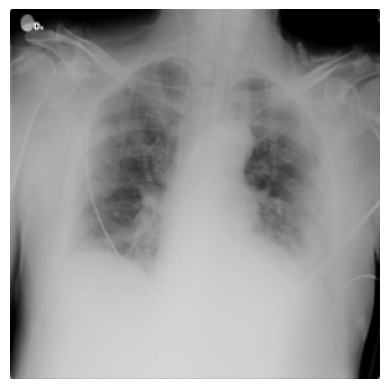

Number of images per class


Class,Count
COVID,3616
Lung Opacity,6012
Normal,10192
Viral Pneumonia,1345


In [5]:
# Show information
image = cv2.imread(clean_covid_folder+'/COVID-1.png', cv2.IMREAD_GRAYSCALE)
df = info(folders=clean_folders, img=image)
df

# 4. TRAINING

Load the data of 'X' and 'y'

In [59]:


# Load lung images
covid_data = load_data(clean_covid_folder, 0)
lung_opacity_data = load_data(clean_lung_opacity_folder, 1)
normal_data = load_data(clean_normal_folder, 2)
viral_pneumonia_data = load_data(clean_viral_pneumonia_folder, 3)
data = covid_data + lung_opacity_data + normal_data + viral_pneumonia_data

# Split the list into two separate lists: one for the data and one for the labels
tensor_list  = [item[0] for item in data]
label_list = [item[1] for item in data]

# Combine the data and labels into an unordered list of tuples
combined_list = list(zip(tensor_list, label_list))
random.shuffle(combined_list)

# Separate the combined list into two separate lists again: one for the data and one for the labels
X, y = zip(*combined_list)
X, y = np.array(X), np.array(y)

Split the data into training and test sets

In [60]:
import time
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.utils import to_categorical

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocess the data
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Check the dimensions of the training and test sets
pd.DataFrame({
    'Variable': ['X train', 'y train',  'X test', 'y test'],
    'Dimensions': [X_train.shape, y_train_categorical.shape, X_test.shape, y_test_categorical.shape],
}).style.hide().set_properties(**{'text-align': 'left'})


Variable,Dimensions
X train,"(14815, 299, 299)"
y train,"(14815, 4)"
X test,"(6350, 299, 299)"
y test,"(6350, 4)"


## Arquitectura 1

In [8]:
# Create the MLP model
model1 = Sequential()
model1.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(128, activation='relu'))
model1.add(Dense(4, activation='softmax'))

# Compile model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
start = time.time()
model1.fit(X_train, y_train_categorical, batch_size=200, epochs=3, verbose=1)
train_time = get_str_time(time.time() - start)

Epoch 1/3
75/75 [==============================] - 41s 453ms/step - loss: 1804.5320 - accuracy: 0.5009
Epoch 2/3
75/75 [==============================] - 20s 266ms/step - loss: 497.8501 - accuracy: 0.5439
Epoch 3/3
75/75 [==============================] - 20s 261ms/step - loss: 363.5261 - accuracy: 0.5650


199/199 [==============================] - 16s 82ms/step


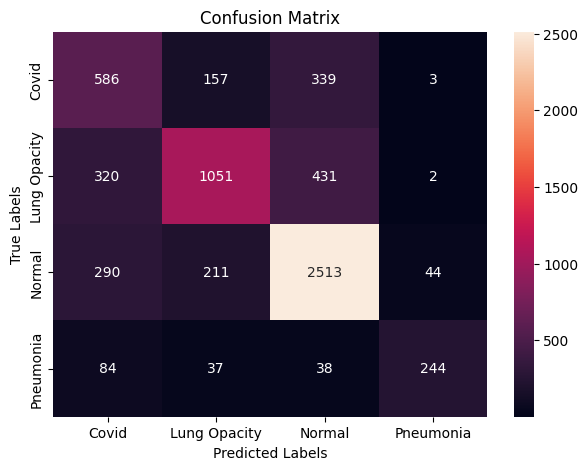

              precision    recall  f1-score   support

       Covid       0.46      0.54      0.50      1085
Lung Opacity       0.72      0.58      0.64      1804
      Normal       0.76      0.82      0.79      3058
   Pneumonia       0.83      0.61      0.70       403

    accuracy                           0.69      6350
   macro avg       0.69      0.64      0.66      6350
weighted avg       0.70      0.69      0.69      6350



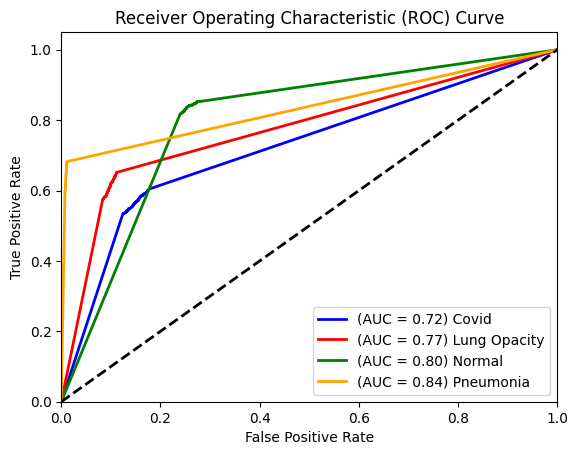

Processing time: 1m 21s



In [32]:
# Evaluate model    
results1 = get_metrics(model=model1, X_test=X_test, y_test=y_test, time=train_time)

# Visualization of Heat Maps

In [61]:

def saliency_map1(model, X_test, images):

    # Get the model predictions
    # predictions  = model.predict(X_test)

    for i in images:
        image = X_test[i]  # Get the image
        image = tf.convert_to_tensor(image, dtype=tf.float32) # Convert the image to a tf.Tensor
        label = np.argmax(y_test_categorical[i])  # Get the true label (converted back to non-categorical form)

        with tf.GradientTape() as tape:
            tape.watch(image)
            predictions = model(image[np.newaxis, ...])
            target_class_predictions = predictions[:, label]
            
        gradients = tape.gradient(target_class_predictions, image)
        heatmap = tf.reduce_max(tf.abs(gradients), axis=-1)
        # Resize the heatmap to match the shape of the input image
        heatmap = tf.image.resize(heatmap, image.shape[:2])
        
        # Display the original image, heatmap, and superimposed image
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(heatmap, cmap='hot', alpha=0.7)
        axes[1].set_title('Saliency Map')
        axes[1].axis('off')
        
        axes[2].imshow(image,  cmap='gray')
        axes[2].imshow(heatmap, cmap='hot', alpha=0.7)
        axes[2].set_title('Image with Saliency Map')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
saliency_map1(model1, X_test, [1,3,5,6])

ValueError: 'images' must have either 3 or 4 dimensions.

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf



# Calcular Saliency Maps
def compute_saliency_maps(model, images, target_class_index):
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
        tape.watch(images)
        # print(images.shape)
        predictions = model(images)
        target_class_predictions = predictions[:, target_class_index]
    gradients = tape.gradient(target_class_predictions, images)
    saliency_maps = tf.reduce_max(tf.abs(gradients), axis=-1)
    return saliency_maps

target_class_index = 0  # Índice de la clase objetivo
saliency_maps = compute_saliency_maps(model1, X_test, target_class_index)

# Visualizar Saliency Maps superpuestas en imágenes (solo 10 imágenes)
def visualize_saliency_maps(images, saliency_maps, num_images=10):
    for i in range(num_images):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(images[i])
        ax1.axis('off')
        ax2.imshow(images[i])
        ax2.imshow(saliency_maps[i], cmap='hot', alpha=0.7)
        ax2.axis('off')
        plt.show()

visualize_saliency_maps(X_test, saliency_maps, num_images=30)



# def saliency_map(model, images, target_class):
    
#     for i in images:
#         # Select an image from the test set for visualization
#         image = X_test[i]  # Get the image
#         label = np.argmax(y_test_categorical[i])  # Get the true label (converted back to non-categorical form)

#         # Convert the image to a tf.Tensor
#         image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

#         # Create a GradientTape to record operations for gradient computation
#         with tf.GradientTape() as tape:
#             tape.watch(image_tensor)
#             predictions = model(image_tensor[np.newaxis, ...])
#             loss = predictions[:, target_class]
#             print(label, predictions)
#             print(label, loss)
#             print()
            
#         gradients = tape.gradient(loss, image_tensor)
#         print(gradients)
#         heatmap = tf.reduce_max(tf.abs(gradients), axis=-1)
#         print(heatmap)
        
#         # Display the original image, heatmap, and superimposed image
#         fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#         axes[0].imshow(image, cmap='gray')
#         axes[0].set_title('Original Image')
#         axes[0].axis('off')
        
#         axes[1].imshow(heatmap, cmap='hot', alpha=0.7)
#         axes[1].set_title('Saliency Map')
#         axes[1].axis('off')
        
#         axes[2].imshow(image,  cmap='gray')
#         axes[2].imshow(heatmap, cmap='hot', alpha=0.7)
#         axes[2].set_title('Image with Saliency Map')
#         axes[2].axis('off')
        
#         plt.tight_layout()
#         plt.show()

# saliency_map(model1, [1,3,5,6], 0)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 89401)             0         
                                                                 
 dense (Dense)               (None, 128)               11443456  
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 11,460,484
Trainable params: 11,460,484
Non-trainable params: 0
_________________________________________________________________


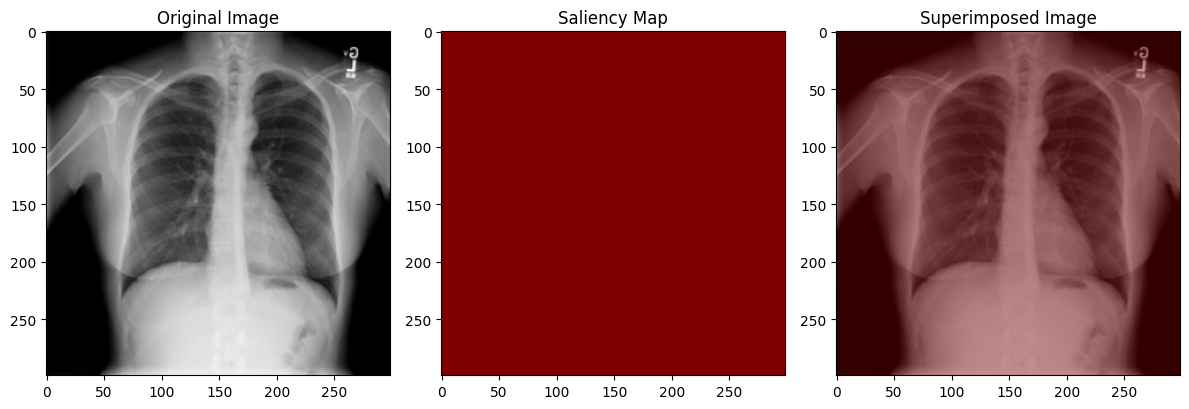

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Select an image from the test set for visualization
index = 2  # Change this index to visualize a different image
image = X_test[index]  # Get the image
label = y_test[index]  # Get the true label

# Convert the image to a tf.Tensor
image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

# Print the summary of model1 to see available layers and their indices
model1.summary()

# Choose a valid layer index based on the desired layer
layer_index = 0  # Change this index to the desired layer

# Create a new model to extract intermediate layer outputs
intermediate_model = tf.keras.Model(inputs=model1.inputs, outputs=model1.layers[layer_index].output)

# Pass the image through the intermediate model to get the activation tensor
activations = intermediate_model(image_tensor)

# Calculate the gradients of the activation tensor with respect to the input image
with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    predictions = model1(image_tensor)
    loss = predictions[0, label]

gradients = tape.gradient(loss, image_tensor)
gradients = tf.reduce_mean(gradients, axis=-1)  # Take the mean across channels

# Normalize the gradients
gradient_min, gradient_max = tf.reduce_min(gradients), tf.reduce_max(gradients)
gradients = (gradients - gradient_min) / (gradient_max - gradient_min + 1e-8)

# Convert the gradients to a heatmap using grayscale colormap
heatmap = cv2.applyColorMap(np.uint8(255 * gradients.numpy()), cv2.COLORMAP_JET)

# Check if the image and heatmap have the same shape and number of channels
if image.shape != heatmap.shape:
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# Superimpose the heatmap on the original image
superimposed = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)

# Display the original image, heatmap, and superimposed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title('Saliency Map')

plt.subplot(1, 3, 3)
plt.imshow(superimposed)
plt.title('Superimposed Image')

plt.tight_layout()
plt.show()


# Convo


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Select an image from the test set for visualization
index = 7  # Change this index to visualize a different image
image = X_test[index]  # Get the image
label = np.argmax(y_test_categorical[index])  # Get the true label (converted back to non-categorical form)

# Convert the image to a tf.Tensor
image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

# Create a GradientTape to record operations for gradient computation
with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    predictions = model1(image_tensor[np.newaxis, ...])
    loss = predictions[0, label]

# Calculate gradients of the loss with respect to the last convolutional layer
last_conv_layer = model1.get_layer(index=-3)  # Get the last convolutional layer
grads = tape.gradient(loss, last_conv_layer.output)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Get the values of the last convolutional layer output and the pooled gradients
last_conv_layer_output = last_conv_layer.output.numpy()[0]
pooled_grads = pooled_grads.numpy()

# Multiply each channel in the last convolutional layer output by the corresponding pooled gradient value
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

# Compute the heatmap by taking the mean along the channel dimension
heatmap = np.mean(last_conv_layer_output, axis=-1)
heatmap = np.maximum(heatmap, 0)  # ReLU activation

# Normalize the heatmap
heatmap /= np.max(heatmap)

# Resize the heatmap to match the original image size
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

# Convert the heatmap to a heatmap overlay
heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
superimposed = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)

# Display the original image, heatmap, and superimposed image
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(heatmap)
axes[1].set_title('Saliency Map')
axes[1].axis('off')
axes[2].imshow(superimposed)
axes[2].set_title('Image with Saliency Map')
axes[2].axis('off')
plt.tight_layout()
plt.show()


AttributeError: 'KerasTensor' object has no attribute '_id'

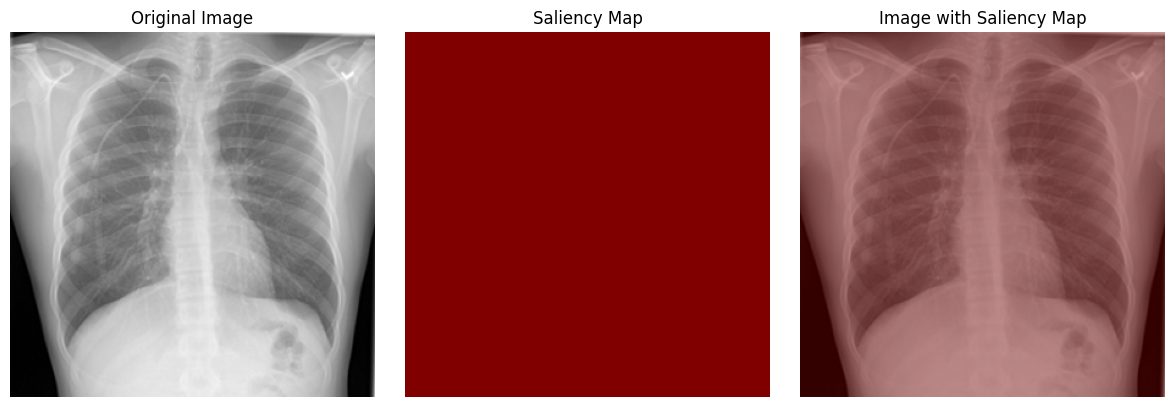

In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def saliency_map(model, images):
    
    for i in images:
        # Select an image from the test set for visualization
        image = X_test[i]  # Get the image

        # Convert the image to a tf.Tensor
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

        # Create a GradientTape to record operations for gradient computation
        with tf.GradientTape() as tape:
            tape.watch(image_tensor)
            predictions = model(image_tensor[np.newaxis, ...])
            loss = predictions[:, 1]
            
        # Calculate gradients of the loss with respect to the input image
        gradients = tape.gradient(loss, image_tensor)
        gradients = gradients.numpy()

        # Normalize the gradients
        gradient_min, gradient_max = np.min(gradients), np.max(gradients)
        gradients = (gradients - gradient_min) / (gradient_max - gradient_min + 1e-8)

        # Convert the gradients to a heatmap using the grayscale colormap
        heatmap = cv2.applyColorMap(np.uint8(255 * gradients), cv2.COLORMAP_JET)

        # Superimpose the heatmap on the original image
        superimposed = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), 0.6, heatmap, 0.4, 0)

        # Display the original image, heatmap, and superimposed image
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        axes[1].imshow(heatmap)
        axes[1].set_title('Saliency Map')
        axes[1].axis('off')
        axes[2].imshow(superimposed)
        axes[2].set_title('Image with Saliency Map')
        axes[2].axis('off')
        plt.tight_layout()
        plt.show()

saliency_map(model1, [100])